<a href="https://colab.research.google.com/github/eferos93/sml_project/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_files
import torch.optim as optim
import os
import numpy as np
import time
from PIL import Image
from torchvision.utils import make_grid
from torchvision import datasets,transforms
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
import copy
from glob import glob

In [2]:
!unzip drive/My\ Drive/5857_1166105_bundle_archive

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360/Training/Tomato 3/124_100.jpg  
  inflating: fruits-360/Training/Tomato 3/125_100.jpg  
  inflating: fruits-360/Training/Tomato 3/126_100.jpg  
  inflating: fruits-360/Training/Tomato 3/127_100.jpg  
  inflating: fruits-360/Training/Tomato 3/128_100.jpg  
  inflating: fruits-360/Training/Tomato 3/129_100.jpg

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
path = '/content/fruits-360/'
files_training = glob(os.path.join(path,'Training', '*/*.jpg'))
num_images = len(files_training)
print('Number of images in Training file:', num_images)

Number of images in Training file: 67692


In [5]:
os.getcwd()
glob(os.path.join(path,'Training', '*/*.jpg'))
os.path.join(path,'Training', '*/*.jpg')

'/content/fruits-360/Training/*/*.jpg'

In [6]:
min_images = 1000
im_cnt = []
class_names = []
print('{:18s}'.format('class'), end='')
print('Count:')
print('-' * 24)
for folder in os.listdir(os.path.join(path, 'Training')):
    folder_num = len(os.listdir(os.path.join(path,'Training',folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
    if (folder_num < min_images):
        min_images = folder_num
        folder_name = folder
        
num_classes = len(class_names)
print("\nMinumum imgages per category:", min_images, 'Category:', folder)    
print('Average number of Images per Category: {:.0f}'.format(np.array(im_cnt).mean()))
print('Total number of classes: {}'.format(num_classes))

class             Count:
------------------------
Granadilla           490
Salak                490
Apple Red 2          492
Strawberry Wedge     738
Tangelo              490
Banana               490
Eggplant             468
Tamarillo            490
Grape Blue           984
Apple Golden 1       480
Passion Fruit        490
Onion White          438
Apple Crimson Snow   444
Peach 2              738
Cantaloupe 2         492
Pitahaya Red         490
Pear Red             666
Kohlrabi             471
Tomato not Ripened   474
Physalis             492
Grape Pink           492
Mango                490
Papaya               492
Potato Red           450
Corn                 450
Pepper Orange        702
Banana Lady Finger   450
Pepper Red           666
Tomato Heart         684
Apple Granny Smith   492
Apple Pink Lady      456
Tomato Cherry Red    492
Maracuja             490
Huckleberry          490
Onion Red            450
Tomato 4             479
Mangostan            300
Apricot              492


In [7]:
tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

all_data = ImageFolder(os.path.join(path, 'Training'), tensor_transform)

In [8]:
data_loader = torch.utils.data.DataLoader(all_data, batch_size=512, shuffle=True)

In [9]:
pop_mean = []
pop_std = []

for i, data in enumerate(data_loader, 0):
    numpy_image = data[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std = np.std(numpy_image, axis=(0,2,3))
    
    pop_mean.append(batch_mean)
    pop_std.append(batch_std)

pop_mean = np.array(pop_mean).mean(axis=0)
pop_std = np.array(pop_std).mean(axis=0)

print(pop_mean)
print(pop_std)

[0.6840374  0.57862514 0.50369114]
[0.30344972 0.35995576 0.39145032]


In [10]:
np.random.seed(123)
shuffle = np.random.permutation(num_images)

In [11]:
split_val = int(num_images * 0.2)
print('Total number of images:', num_images)
print('Number of valid images after split:',len(shuffle[:split_val]))
print('Number of train images after split:',len(shuffle[split_val:]))

Total number of images: 67692
Number of valid images after split: 13538
Number of train images after split: 54154


In [12]:
class FruitTrainDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[split_val:]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

class FruitValidDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[:split_val]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y
    
class FruitTestDataset(Dataset):
    def __init__(self, path, class_names, transform=transforms.ToTensor()):
        self.class_names = class_names
        self.data = np.array(glob(os.path.join(path, '*/*.jpg')))
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ]),
    'Test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ])
}

train_dataset = FruitTrainDataset(files_training, shuffle, split_val, class_names, data_transforms['train'])
valid_dataset = FruitValidDataset(files_training, shuffle, split_val, class_names, data_transforms['valid'])
test_dataset = FruitTestDataset('/content/fruits-360/Test', class_names, transform=data_transforms['Test'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [14]:
dataloaders = {'train': train_loader,
              'valid': valid_loader,
              'Test': test_loader}
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'Test': len(test_dataset)
}

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = pop_std * inp + pop_mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

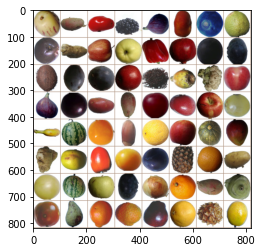

['Pepino', 'Potato Red', 'Tomato 2', 'Mulberry', 'Fig', 'Nectarine Flat', 'Huckleberry', 'Limes', 'Passion Fruit', 'Ginger Root', 'Apple Red 1', 'Apple Golden 2', 'Pepper Red', 'Pomegranate', 'Grape Blue', 'Blueberry', 'Cocos', 'Plum 3', 'Plum 3', 'Apple Braeburn', 'Rambutan', 'Cactus fruit', 'Cauliflower', 'Cherry Rainier', 'Fig', 'Cherry Wax Black', 'Potato Red Washed', 'Potato Red', 'Cherry Wax Red', 'Cherry 2', 'Apple Braeburn', 'Grape White', 'Banana Lady Finger', 'Watermelon', 'Physalis', 'Hazelnut', 'Cantaloupe 1', 'Apple Crimson Snow', 'Melon Piel de Sapo', 'Mango Red', 'Ginger Root', 'Pomelo Sweetie', 'Kaki', 'Cherry Wax Yellow', 'Plum 3', 'Pineapple', 'Orange', 'Potato White', 'Grape White 2', 'Watermelon', 'Apple Golden 3', 'Blueberry', 'Onion White', 'Lemon Meyer', 'Potato Red', 'Kohlrabi', 'Tomato Maroon', 'Pear Stone', 'Tangelo', 'Mandarine', 'Apple Red Delicious', 'Grapefruit White', 'Pineapple Mini', 'Maracuja']


In [16]:
inputs, classes = next(iter(train_loader))
out = make_grid(inputs)

cats = ['' for x in range(len(classes))]
for i in range(len(classes)):
    cats[i] = class_names[classes[i].item()]
    
imshow(out)
print(cats)

# Network

In [ ]:
model = torchvision.models.vgg11(num_classes)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
exp_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth


In [22]:
def train(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time() # allows us to keep track of how long it took
    
    best_acc = 0.0 # allows us to store the best_acc rate (for validation stage)
    losses = {'train': [], 'valid': []}
    accuracies = {'train': [], 'valid': []}
    # Loop through the data-set num_epochs times.
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 15)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train() # This sets the model to training mode
            else:
                model.eval() # this sets the model to evaluation mode 
                
            running_loss = 0.0
            running_corrects = 0
            
            # using the dataloaders to load data in batches
            for inputs, labels in dataloaders[phase]:
                # putting the inputs and labels on cuda (gpu)
                inputs = inputs.to(device) 
                labels = labels.to(device)
                
                # zero the gradient
                optimizer.zero_grad()
                
                # if training phase, allow calculating the gradient, but don't allow otherwise
                with torch.set_grad_enabled(phase == 'train'):
                    # get outputs and predictions
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels) # get value of loss function with the current weights 
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            # keep track of the best weights for the validation dataset 
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

In [ ]:
model = train(model, criterion, optimizer,
                         exp_scheduler, num_epochs=30)

vgg11_train_loss = [1.4281, 0.0528, 0.0184, 0.0278, 0.0065, 0.0046, 0.0018, 0.0013
                    0.0013, 0.0014, 0.0009, 0.001, 0.0009, 0.0008, 0.001, 0.0007, 
                    0.0009, 0.0009, 0.0006, 0.0008, 0.0007, 0.001, 0.0008, 0.0007,
                    0.0008, 0.0006, 0.0007,0.0006,0.0006]
vgg11_valid_loss = [0.1653, 0.0116, 0.0014, 0.0005, 0.0003, 0.0001, 0.0001, 0.0,
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

Epoch 0/29
---------------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.4281 Acc: 0.6859
valid Loss: 0.1653 Acc: 0.9734

Epoch 1/29
---------------
train Loss: 0.0528 Acc: 0.9848
valid Loss: 0.0116 Acc: 0.9965

Epoch 2/29
---------------
train Loss: 0.0184 Acc: 0.9946
valid Loss: 0.0014 Acc: 0.9996

Epoch 3/29
---------------
train Loss: 0.0278 Acc: 0.9940
valid Loss: 0.0005 Acc: 0.9999

Epoch 4/29
---------------
train Loss: 0.0065 Acc: 0.9984
valid Loss: 0.0003 Acc: 1.0000

Epoch 5/29
---------------
train Loss: 0.0046 Acc: 0.9988
valid Loss: 0.0001 Acc: 1.0000

Epoch 6/29
---------------
train Loss: 0.0018 Acc: 0.9997
valid Loss: 0.0001 Acc: 1.0000

Epoch 7/29
---------------
train Loss: 0.0013 Acc: 0.9997
valid Loss: 0.0000 Acc: 1.0000

Epoch 8/29
---------------
train Loss: 0.0014 Acc: 0.9996
valid Loss: 0.0000 Acc: 1.0000

Epoch 9/29
---------------
train Loss: 0.0009 Acc: 0.9999
valid Loss: 0.0000 Acc: 1.0000

Epoch 10/29
---------------
train Loss: 0.0010 Acc: 0.9998
valid Loss: 0.0000 Acc: 1.0000

Epoch 11/29
---------------
train Lo

In [25]:
def get_accuracy(model):
  correct = 0
  total = 0
  with torch.no_grad():
      for images, labels in dataloaders['Test']:
          images = images.to(device)
          labels = labels.to(device)
          
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the {} test images: {:.3f}%'.format(dataset_sizes['Test'], 
                                                                        100 * correct / dataset_sizes['Test']))

## ResNet


In [ ]:
model_resnet = torchvision.models.resnet18(num_classes) #https://arxiv.org/abs/1512.03385
model_resnet.to(device)

optimizer = optim.SGD(model_resnet.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
exp_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
model_resnet = train(model_resnet, criterion, optimizer, exp_scheduler)

Epoch 0/29
---------------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.4148 Acc: 0.9374
valid Loss: 0.0091 Acc: 0.9993

Epoch 1/29
---------------
train Loss: 0.0117 Acc: 0.9992
valid Loss: 0.1963 Acc: 0.9557

Epoch 2/29
---------------
train Loss: 0.0073 Acc: 0.9995
valid Loss: 0.0025 Acc: 0.9999

Epoch 3/29
---------------
train Loss: 0.0043 Acc: 0.9999
valid Loss: 0.0013 Acc: 0.9999

Epoch 4/29
---------------
train Loss: 0.0033 Acc: 0.9999
valid Loss: 0.4097 Acc: 0.9229

Epoch 5/29
---------------
train Loss: 0.0037 Acc: 0.9998
valid Loss: 0.0500 Acc: 0.9858

Epoch 6/29
---------------
train Loss: 0.0034 Acc: 0.9997
valid Loss: 0.0006 Acc: 1.0000

Epoch 7/29
---------------
train Loss: 0.0024 Acc: 1.0000
valid Loss: 0.0007 Acc: 1.0000

Epoch 8/29
---------------
train Loss: 0.0023 Acc: 0.9999
valid Loss: 0.0006 Acc: 1.0000

Epoch 9/29
---------------
train Loss: 0.0022 Acc: 0.9999
valid Loss: 0.0006 Acc: 1.0000

Epoch 10/29
---------------
train Loss: 0.0023 Acc: 0.9998
valid Loss: 0.0006 Acc: 1.0000

Epoch 11/29
---------------
train Lo

In [ ]:
get_accuracy(model_resnet)

Accuracy of the network on the 22688 test images: 98.563%


In [ ]:
model_resNext = torchvision.models.resnext50_32x4d().to(device)

optimizer = optim.SGD(model_resnet.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
exp_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model_resNext = train(model_resNext, criterion, optimizer, exp_scheduler)

Epoch 0/29
---------------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 7.1026 Acc: 0.0024
valid Loss: 7.0937 Acc: 0.0032

Epoch 1/29
---------------
train Loss: 7.1027 Acc: 0.0021
valid Loss: 7.0930 Acc: 0.0033

Epoch 2/29
---------------
train Loss: 7.1031 Acc: 0.0021
valid Loss: 7.0952 Acc: 0.0033

Epoch 3/29
---------------
train Loss: 7.1019 Acc: 0.0023
valid Loss: 7.0890 Acc: 0.0028

Epoch 4/29
---------------
train Loss: 7.1034 Acc: 0.0025
valid Loss: 7.0886 Acc: 0.0027

Epoch 5/29
---------------
train Loss: 7.1036 Acc: 0.0026
valid Loss: 7.0952 Acc: 0.0031

Epoch 6/29
---------------


KeyboardInterrupt: ignored

In [ ]:
get_accuracy(model_resNext)

In [ ]:
model_vgg19 = torchvision.models.vgg19().to(device)

optimizer = optim.SGD(model_vgg19.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
exp_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model_vgg19 = train(model_vgg19, criterion, optimizer, exp_scheduler)
train_loss_vgg19 = [4.5227, 2.6754, 1.4546, 0.7787, 0.4606, 0.3993, 0.0765, 0.0504,
                    0.0391, 0.0338, 0.0286, 0.0249, 0.0226, 0.0196, 0.0169, 0.0181,
                    0.0170, 0.0165, 0.0163, 0.0153, 0.0166. 0.0160, 0.0158, 0.0164,
                    0.0153, 0.0163, 0.0159, 0.0161, 0.0157, 0.0154]
valid_loss_vgg19 = [3.3770, 2.3996, 1.5606, 2.3814, 0.2460, 0.0938, 0.025, 0.0181,
                    0.0131, 0.0101, 0.0094, 0.0078, 0.0064, 0.0055, 0.0053, 0.0051,
                    0.005, 0.0048, 0.0047, 0.0047, 0.0046, 0.0046, 0.0046, 0.0046,
                    0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045]

Epoch 0/29
---------------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 4.5227 Acc: 0.0396
valid Loss: 3.3770 Acc: 0.0906

Epoch 1/29
---------------
train Loss: 2.6754 Acc: 0.2500
valid Loss: 2.3996 Acc: 0.3756

Epoch 2/29
---------------
train Loss: 1.4546 Acc: 0.5584
valid Loss: 1.5606 Acc: 0.5434

Epoch 3/29
---------------
train Loss: 0.7787 Acc: 0.7533
valid Loss: 2.3814 Acc: 0.5153

Epoch 4/29
---------------
train Loss: 0.4606 Acc: 0.8551
valid Loss: 0.2460 Acc: 0.9219

Epoch 5/29
---------------
train Loss: 0.3993 Acc: 0.8785
valid Loss: 0.0938 Acc: 0.9676

Epoch 6/29
---------------
train Loss: 0.0765 Acc: 0.9752
valid Loss: 0.0250 Acc: 0.9927

Epoch 7/29
---------------
train Loss: 0.0504 Acc: 0.9840
valid Loss: 0.0181 Acc: 0.9949

Epoch 8/29
---------------
train Loss: 0.0391 Acc: 0.9874
valid Loss: 0.0131 Acc: 0.9964

Epoch 9/29
---------------
train Loss: 0.0338 Acc: 0.9890
valid Loss: 0.0101 Acc: 0.9973

Epoch 10/29
---------------
train Loss: 0.0286 Acc: 0.9904
valid Loss: 0.0094 Acc: 0.9973

Epoch 11/29
---------------
train Lo

In [ ]:
get_accuracy(model_vgg19)

Accuracy of the network on the 22688 test images: 91.859%


## Transfer Learning

In [ ]:
tl_model_resnet = torchvision.models.resnet18(pretrained=True).to(device)

#optimizer = optim.SGD(tl_model_resnet.parameters(), lr=0.01)
optimizer = optim.Adam(tl_model_resnet.parameters())
criterion = nn.CrossEntropyLoss()
exp_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
def train_tl(model, optimizer, criterion, num_epochs = 2):
  hist = {'loss': [], 'val_loss': [], 'val_acc': []}
  for epoch in range(num_epochs):
      print('Starting epoch {}/{}'.format(epoch+1, num_epochs))
      # train
      model.train()
      running_loss = 0.0
      for images, labels in train_loader:
          images = Variable(images.cuda())
          labels = Variable(labels.cuda())
          
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          
          running_loss += loss.data[0]
      
      train_loss = running_loss / len(train_loader)
      
      # evalute
      model.eval()
      val_running_loss = 0.0
      correct = 0
      for images, labels in test_loader:
          images = Variable(images.cuda())
          labels = Variable(labels.cuda())
          
          outputs = model(images)
          loss = criterion(outputs, labels)
          
          val_running_loss += loss.data[0]
          _, predicted = torch.max(outputs.data, 1)
          correct += (predicted == labels.data).sum()
      
      
      val_loss = val_running_loss / len(test_loader)
      val_acc = correct / len(test_dataset)
      
      hist['loss'].append(train_loss)
      hist['val_loss'].append(val_loss)
      hist['val_acc'].append(val_acc)
      
      print('loss: {:.4f}  val_loss: {:.4f} val_acc: {:4.4f}\n'.format(train_loss, val_loss, val_acc))
      return model, hist

In [ ]:
tl_model_resnet, histogram = train_tl(tl_model_resnet, optimizer, criterion)

Starting epoch 1/2


IndexError: ignored

In [ ]:
torch.save(model_resnet, 'resnet_18')

In [ ]:
torch.save(model_vgg19, 'vgg19')

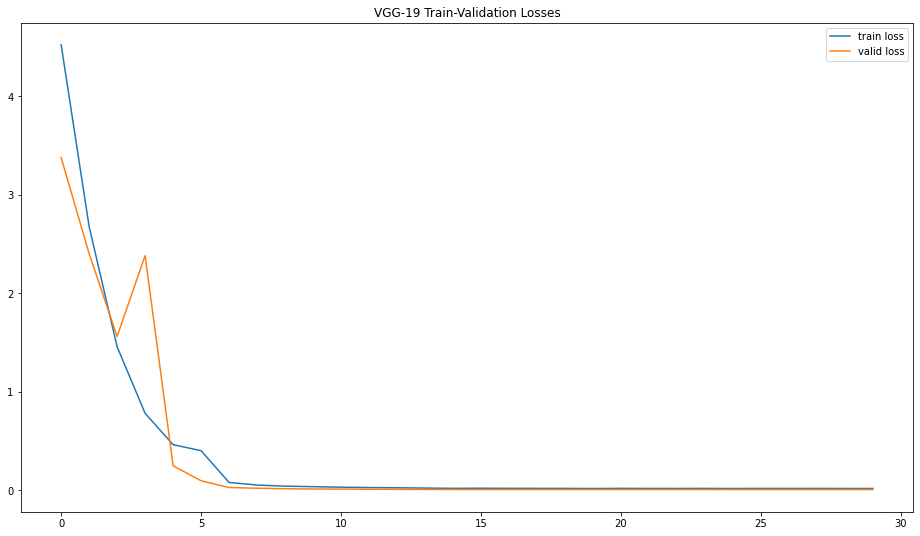

In [ ]:
train_loss_vgg19 = [4.5227, 2.6754, 1.4546, 0.7787, 0.4606, 0.3993, 0.0765, 0.0504,
                    0.0391, 0.0338, 0.0286, 0.0249, 0.0226, 0.0196, 0.0169, 0.0181,
                    0.0170, 0.0165, 0.0163, 0.0153, 0.0166, 0.0160, 0.0158, 0.0164,
                    0.0153, 0.0163, 0.0159, 0.0161, 0.0157, 0.0154]
valid_loss_vgg19 = [3.3770, 2.3996, 1.5606, 2.3814, 0.2460, 0.0938, 0.025, 0.0181,
                    0.0131, 0.0101, 0.0094, 0.0078, 0.0064, 0.0055, 0.0053, 0.0051,
                    0.005, 0.0048, 0.0047, 0.0047, 0.0046, 0.0046, 0.0046, 0.0046,
                    0.0045, 0.0045, 0.0045, 0.0045, 0.0045, 0.0045]
plt.figure(figsize=(16, 9))
_ = plt.plot(range(0,30), train_loss_vgg19, label="train loss")
_ = plt.plot(range(0,30), valid_loss_vgg19, label="valid loss")
_ = plt.title("VGG-19 Train-Validation Losses")
_ = plt.legend()

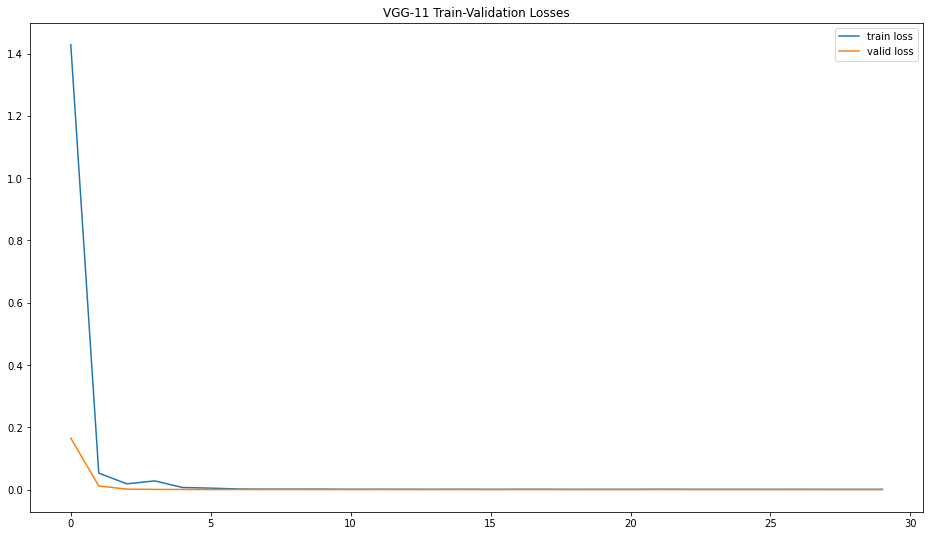

In [ ]:
vgg11_train_loss = [1.4281, 0.0528, 0.0184, 0.0278, 0.0065, 0.0046, 0.0018, 0.0013,
                    0.0013, 0.0014, 0.0009, 0.001, 0.0009, 0.0008, 0.001, 0.0007, 
                    0.0009, 0.0009, 0.0006, 0.0008, 0.0007, 0.001, 0.0008, 0.0007,
                    0.0008, 0.0006, 0.0007,0.0006,0.0006,0.0006]

vgg11_valid_loss = [0.1653, 0.0116, 0.0014, 0.0005, 0.0003, 0.0001, 0.0001, 0.0,
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

plt.figure(figsize=(16, 9))
_ = plt.plot(range(0,30), vgg11_train_loss, label="train loss")
_ = plt.plot(range(0,30), vgg11_valid_loss, label="valid loss")
_ = plt.title("VGG-11 Train-Validation Losses")
_ = plt.legend()           

In [18]:
model = torchvision.models.vgg11(num_classes)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
exp_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth


In [23]:
#vgg11 15 epochs
model, loss_vgg11_15ep, acc_vgg1_15ep = train(model, criterion, optimizer,
                                              exp_scheduler, num_epochs=15)

Epoch 0/14
---------------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.4009 Acc: 0.6862
valid Loss: 0.0288 Acc: 0.9922

Epoch 1/14
---------------
train Loss: 0.0516 Acc: 0.9844
valid Loss: 0.0036 Acc: 0.9992

Epoch 2/14
---------------
train Loss: 0.0168 Acc: 0.9953
valid Loss: 0.0112 Acc: 0.9961

Epoch 3/14
---------------
train Loss: 0.0092 Acc: 0.9973
valid Loss: 0.0005 Acc: 0.9999

Epoch 4/14
---------------
train Loss: 0.0121 Acc: 0.9969
valid Loss: 0.0003 Acc: 0.9999

Epoch 5/14
---------------
train Loss: 0.0053 Acc: 0.9987
valid Loss: 0.0002 Acc: 0.9999

Epoch 6/14
---------------
train Loss: 0.0015 Acc: 0.9996
valid Loss: 0.0002 Acc: 0.9999

Epoch 7/14
---------------
train Loss: 0.0011 Acc: 0.9998
valid Loss: 0.0001 Acc: 0.9999

Epoch 8/14
---------------
train Loss: 0.0011 Acc: 0.9997
valid Loss: 0.0001 Acc: 0.9999

Epoch 9/14
---------------
train Loss: 0.0008 Acc: 0.9999
valid Loss: 0.0001 Acc: 1.0000

Epoch 10/14
---------------
train Loss: 0.0010 Acc: 0.9998
valid Loss: 0.0001 Acc: 0.9999

Epoch 11/14
---------------
train Lo

In [26]:
get_accuracy(model)

Accuracy of the network on the 22688 test images: 99.004%


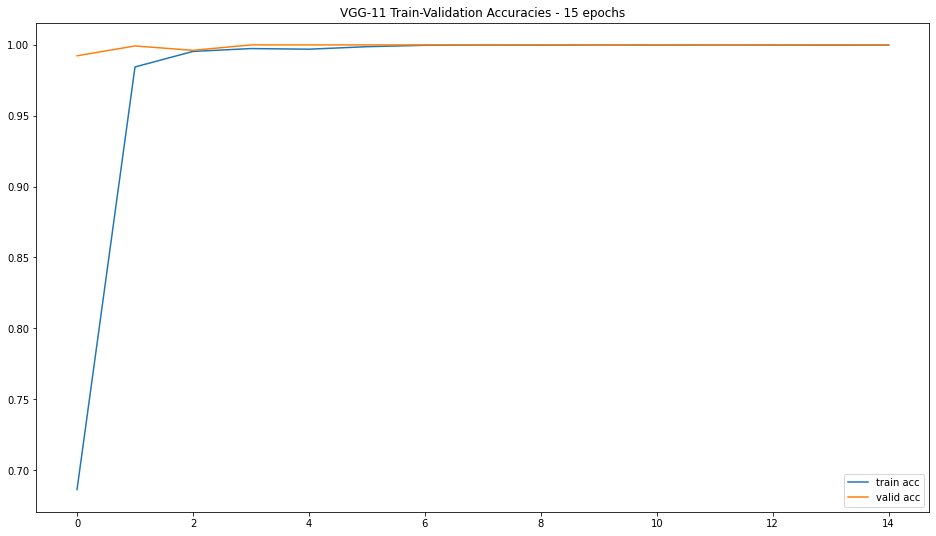

In [37]:
plt.figure(figsize=(16, 9))
_ = plt.plot(range(0,15), acc_vgg1_15ep['train'], label="train acc")
_ = plt.plot(range(0,15), acc_vgg1_15ep['valid'], label="valid acc")
_ = plt.title("VGG-11 Train-Validation Accuracies - 15 epochs")
_ = plt.legend()  

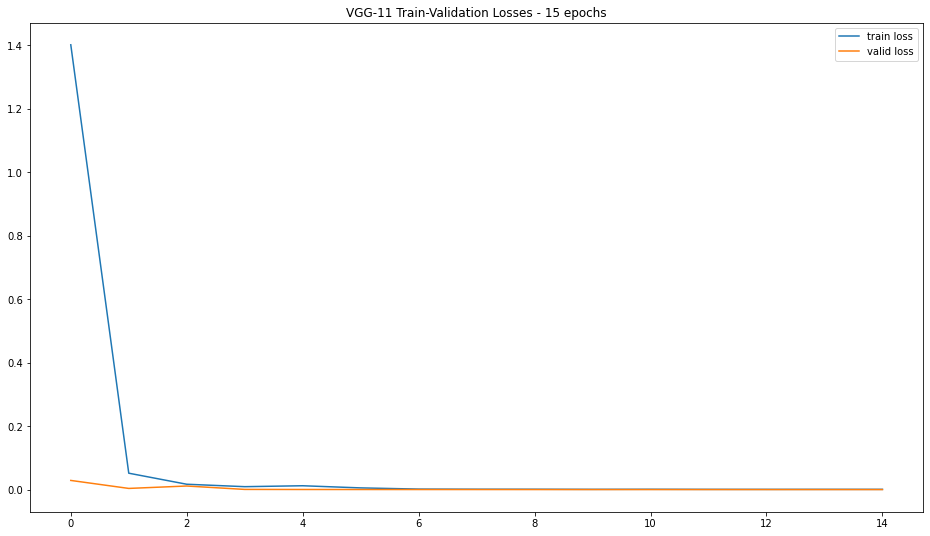

In [38]:
plt.figure(figsize=(16, 9))
_ = plt.plot(range(0,15), loss_vgg11_15ep['train'], label="train loss")
_ = plt.plot(range(0,15), loss_vgg11_15ep['valid'], label="valid loss")
_ = plt.title("VGG-11 Train-Validation Losses - 15 epochs")
_ = plt.legend()  

In [32]:
model_resNet18_15ep = torchvision.models.resnet18().to(device)

optimizer = optim.SGD(model_resNet18_15ep.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
exp_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [33]:
model_resNet18_15ep, loss_resnet18_15ep, acc_resnet18_15ep = train(model_resNet18_15ep,
                                                            criterion, optimizer,
                                                            exp_scheduler, num_epochs=15)

Epoch 0/14
---------------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 2.7283 Acc: 0.4616
valid Loss: 1.6419 Acc: 0.5168

Epoch 1/14
---------------
train Loss: 0.6784 Acc: 0.8649
valid Loss: 0.4937 Acc: 0.8539

Epoch 2/14
---------------
train Loss: 0.3094 Acc: 0.9406
valid Loss: 2.2769 Acc: 0.6057

Epoch 3/14
---------------
train Loss: 0.1813 Acc: 0.9659
valid Loss: 2.1744 Acc: 0.5386

Epoch 4/14
---------------
train Loss: 0.1149 Acc: 0.9807
valid Loss: 0.1995 Acc: 0.9388

Epoch 5/14
---------------
train Loss: 0.0846 Acc: 0.9865
valid Loss: 1.1875 Acc: 0.7695

Epoch 6/14
---------------
train Loss: 0.0591 Acc: 0.9926
valid Loss: 0.0215 Acc: 0.9996

Epoch 7/14
---------------
train Loss: 0.0527 Acc: 0.9946
valid Loss: 0.0175 Acc: 0.9998

Epoch 8/14
---------------
train Loss: 0.0487 Acc: 0.9952
valid Loss: 0.0233 Acc: 0.9977

Epoch 9/14
---------------
train Loss: 0.0468 Acc: 0.9958
valid Loss: 0.0161 Acc: 0.9998

Epoch 10/14
---------------
train Loss: 0.0454 Acc: 0.9959
valid Loss: 0.0181 Acc: 0.9996

Epoch 11/14
---------------
train Lo

In [34]:
get_accuracy(model_resNet18_15ep)

Accuracy of the network on the 22688 test images: 97.999%


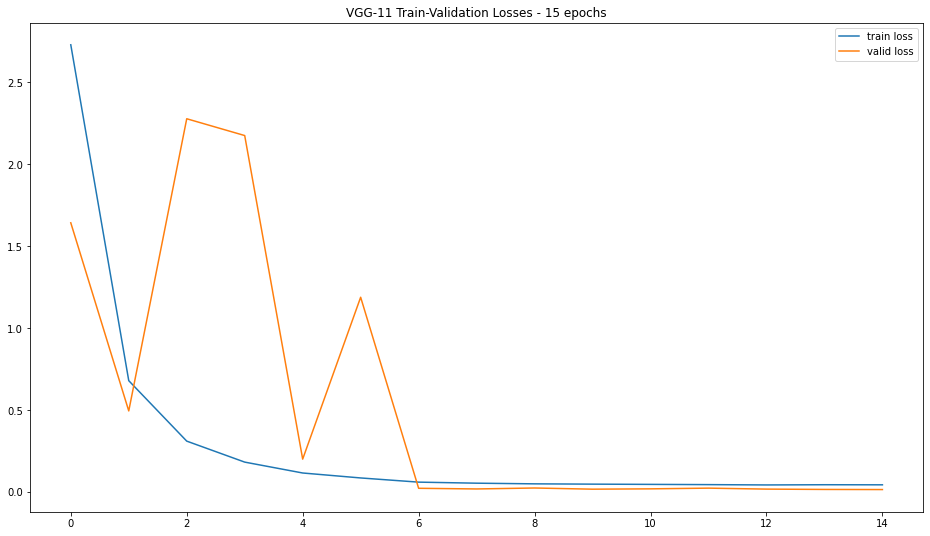

In [35]:
plt.figure(figsize=(16, 9))
_ = plt.plot(range(0,15), loss_resnet18_15ep['train'], label="train loss")
_ = plt.plot(range(0,15), loss_resnet18_15ep['valid'], label="valid loss")
_ = plt.title("ResNet18 Train-Validation Losses - 15 epochs")
_ = plt.legend()  

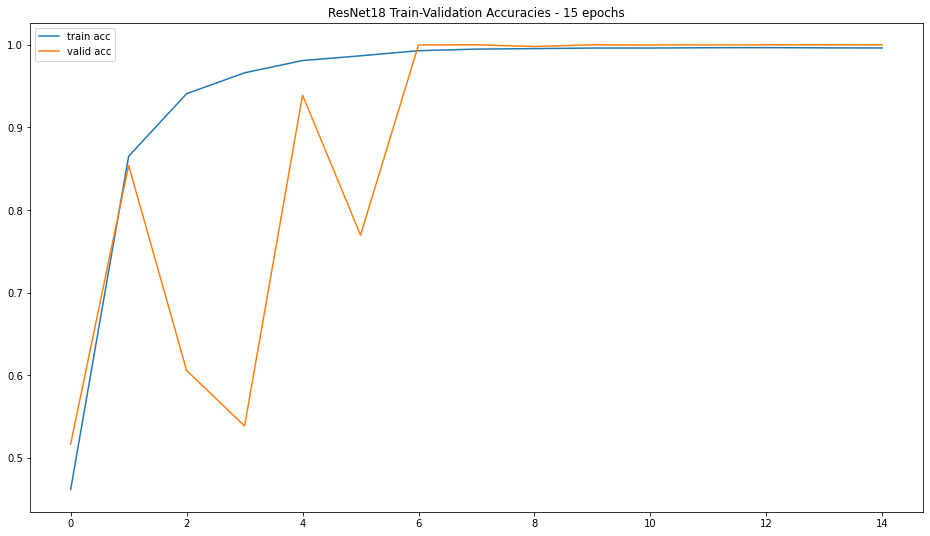

In [36]:
plt.figure(figsize=(16, 9))
_ = plt.plot(range(0,15), acc_resnet18_15ep['train'], label="train acc")
_ = plt.plot(range(0,15), acc_resnet18_15ep['valid'], label="valid acc")
_ = plt.title("ResNet18 Train-Validation Accuracies - 15 epochs")
_ = plt.legend()  

In [39]:
model = torchvision.models.vgg11(num_classes)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
exp_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [40]:
model, loss_vgg11_10ep, acc_vgg11_10ep = train(model, criterion, optimizer,
                                               exp_scheduler, num_epochs=10)

Epoch 0/9
---------------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.4720 Acc: 0.6732
valid Loss: 0.1262 Acc: 0.9614

Epoch 1/9
---------------
train Loss: 0.0544 Acc: 0.9848
valid Loss: 0.0135 Acc: 0.9963

Epoch 2/9
---------------
train Loss: 0.0221 Acc: 0.9939
valid Loss: 0.0044 Acc: 0.9985

Epoch 3/9
---------------
train Loss: 0.0097 Acc: 0.9977
valid Loss: 0.0007 Acc: 0.9999

Epoch 4/9
---------------
train Loss: 0.0074 Acc: 0.9981
valid Loss: 0.0002 Acc: 1.0000

Epoch 5/9
---------------
train Loss: 0.0059 Acc: 0.9982
valid Loss: 0.0008 Acc: 0.9998

Epoch 6/9
---------------
train Loss: 0.0016 Acc: 0.9997
valid Loss: 0.0001 Acc: 1.0000

Epoch 7/9
---------------
train Loss: 0.0012 Acc: 0.9998
valid Loss: 0.0001 Acc: 1.0000

Epoch 8/9
---------------
train Loss: 0.0013 Acc: 0.9997
valid Loss: 0.0000 Acc: 1.0000

Epoch 9/9
---------------
train Loss: 0.0009 Acc: 0.9999
valid Loss: 0.0000 Acc: 1.0000

Training complete in 25m 0s
Best validation Acc: 1.000000


In [41]:
get_accuracy(model)

Accuracy of the network on the 22688 test images: 98.647%


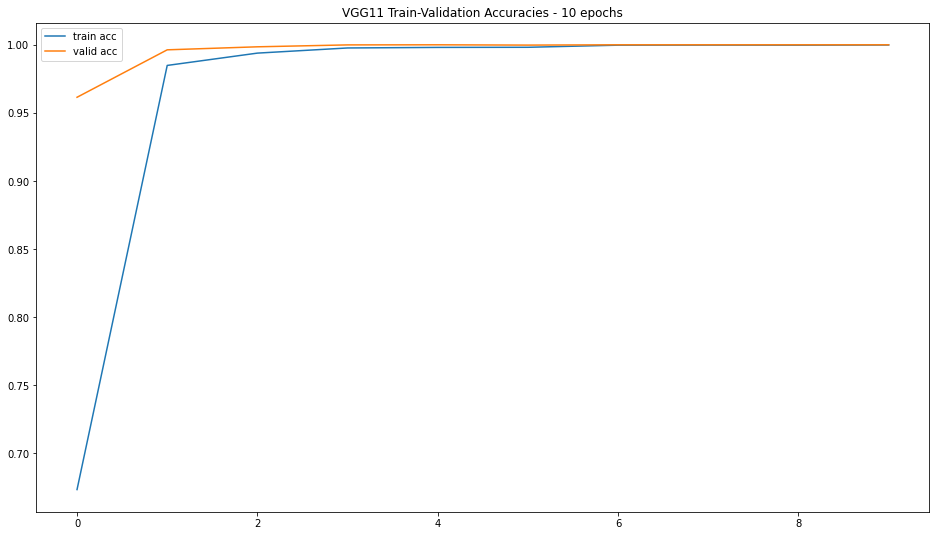

In [42]:
plt.figure(figsize=(16, 9))
_ = plt.plot(range(0,10), acc_vgg11_10ep['train'], label="train acc")
_ = plt.plot(range(0,10), acc_vgg11_10ep['valid'], label="valid acc")
_ = plt.title("VGG11 Train-Validation Accuracies - 10 epochs")
_ = plt.legend()  

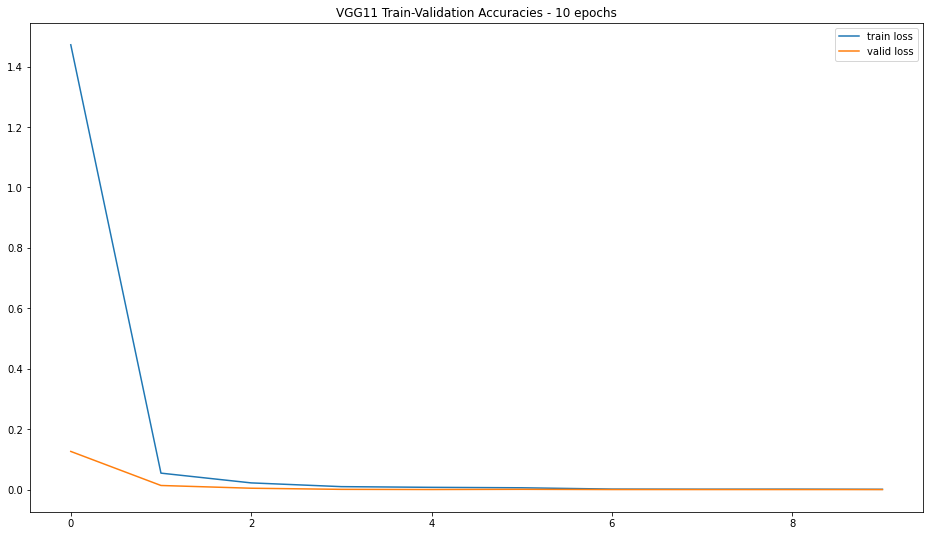

In [43]:
plt.figure(figsize=(16, 9))
_ = plt.plot(range(0,10), loss_vgg11_10ep['train'], label="train loss")
_ = plt.plot(range(0,10), loss_vgg11_10ep['valid'], label="valid loss")
_ = plt.title("VGG11 Train-Validation Losses - 10 epochs")
_ = plt.legend()  

In [44]:
model_resNet18_10ep = torchvision.models.resnet18().to(device)

optimizer = optim.SGD(model_resNet18_10ep.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
exp_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [45]:
model_resNet18_10ep, loss_resnet18_10ep, acc_resnet18_10ep = train(model_resNet18_10ep,
                                                                   criterion,
                                                                   optimizer,
                                                                   exp_scheduler,
                                                                   num_epochs=10)

Epoch 0/9
---------------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 2.8009 Acc: 0.4534
valid Loss: 1.1618 Acc: 0.7146

Epoch 1/9
---------------
train Loss: 0.7284 Acc: 0.8512
valid Loss: 0.8223 Acc: 0.7635

Epoch 2/9
---------------
train Loss: 0.3413 Acc: 0.9325
valid Loss: 0.8550 Acc: 0.7627

Epoch 3/9
---------------
train Loss: 0.1892 Acc: 0.9666
valid Loss: 3.3501 Acc: 0.4069

Epoch 4/9
---------------
train Loss: 0.1221 Acc: 0.9798
valid Loss: 1.9508 Acc: 0.5504

Epoch 5/9
---------------
train Loss: 0.0875 Acc: 0.9864
valid Loss: 3.6209 Acc: 0.4234

Epoch 6/9
---------------
train Loss: 0.0744 Acc: 0.9894
valid Loss: 0.0288 Acc: 0.9989

Epoch 7/9
---------------
train Loss: 0.0565 Acc: 0.9938
valid Loss: 0.0228 Acc: 0.9993

Epoch 8/9
---------------
train Loss: 0.0524 Acc: 0.9948
valid Loss: 0.0223 Acc: 0.9992

Epoch 9/9
---------------
train Loss: 0.0506 Acc: 0.9949
valid Loss: 0.0861 Acc: 0.9770

Training complete in 15m 21s
Best validation Acc: 0.999335


In [47]:
get_accuracy(model_resNet18_10ep)

Accuracy of the network on the 22688 test images: 97.734%


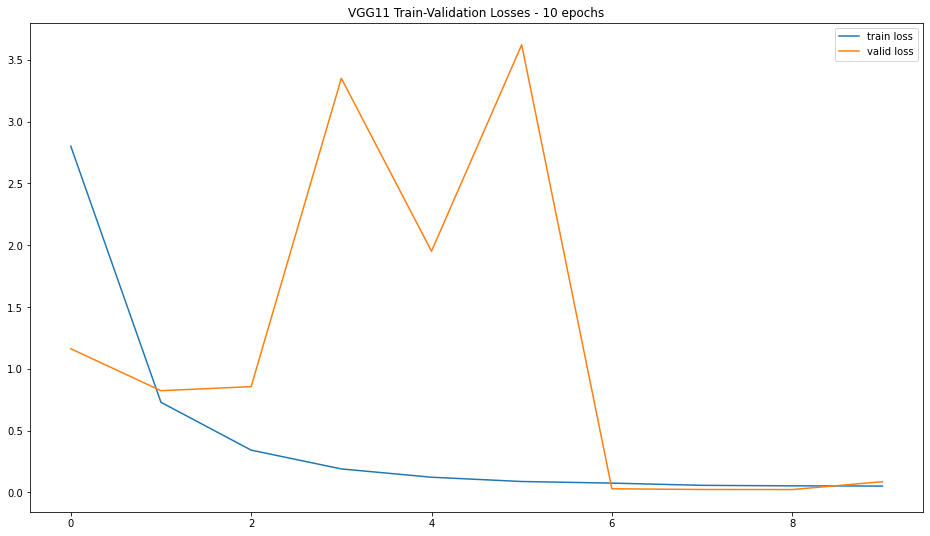

In [48]:
plt.figure(figsize=(16, 9))
_ = plt.plot(range(0,10), loss_resnet18_10ep['train'], label="train loss")
_ = plt.plot(range(0,10), loss_resnet18_10ep['valid'], label="valid loss")
_ = plt.title("VGG11 Train-Validation Losses - 10 epochs")
_ = plt.legend()  

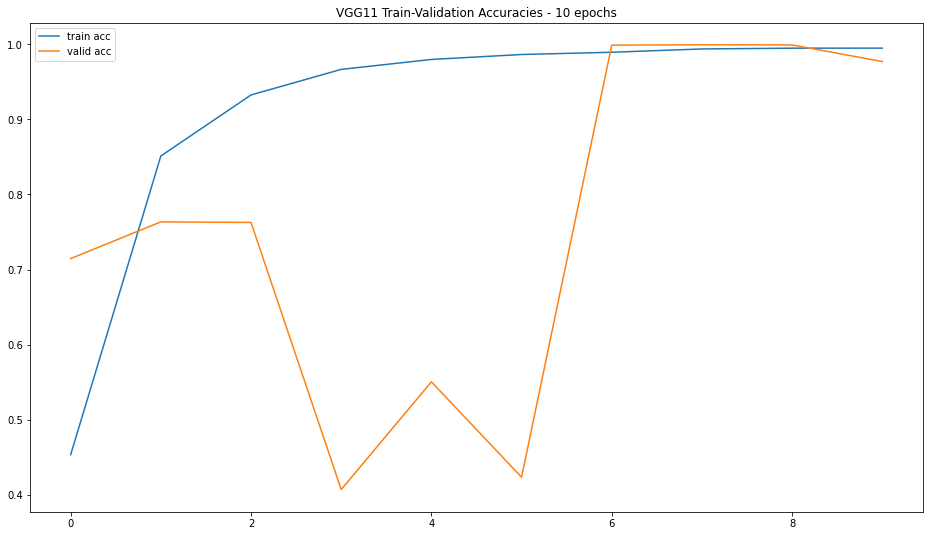

In [49]:
plt.figure(figsize=(16, 9))
_ = plt.plot(range(0,10), acc_resnet18_10ep['train'], label="train acc")
_ = plt.plot(range(0,10), acc_resnet18_10ep['valid'], label="valid acc")
_ = plt.title("VGG11 Train-Validation Accuracies - 10 epochs")
_ = plt.legend()  